# Super Hero Degress of Separation
##### An iterative Breadth-First-Search implementation in Spark, and introducing accumulators

## BFS in Action

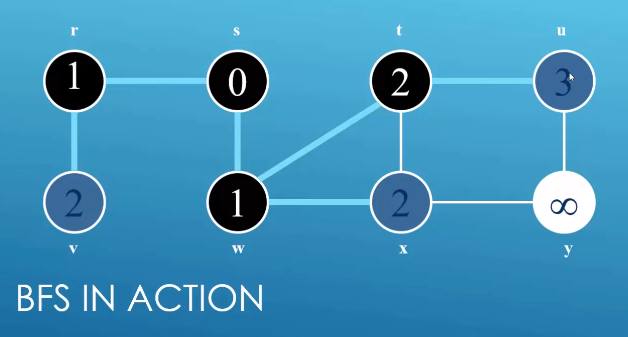

## Implementing BFS in Spark
- Represent each line as anode with connections, a color, and a distance.
For example: \
`5983 1165 3836 4361 1282` \
becomes \
`(5983, (1165, 3836, 4361, 1282), 9999, WHITE)`
- Our initial condition is that a node is infinitely distant (9999) and white

## Map Function to convert Marvel-Graph.txt to BFS Nodes

```
def convertToBFS(line):
    fields = line.split()
    heroID = int(fields[0])
    connections = []
    for connection in fields[1:]:
        connections.append(int(connection))
        
    color = "WHITE"
    distance = 9999
    
    if(heroID == startCharacterID):
        color = 'GRAY'
    distance = 0
    
    return (heroID, (connections, distance, color))
```

## Iteratively process the RDD
- Just like each step of our BFS example..
- Go through, looking for gray nodes to expand
- Color nodes we're done with black
- Update the distances as we go

## A BFS Iteration as a map and reduce job
- The mapper
    - Creates new nodes for each connection of gray nodes, with a distance incremented by one, color gray, and no connections
    - Colors the gray node we just processed black
    - Copies the node itself into the results
- The reducer:
    - Combines together all nodes for the same hero ID
    - Preserves the shortest distance, and the darkest color found.
    - Preserves the list of connections from the original node.
    
## How do we know when we're done?
- An accumulator allows many executors to increment a shared variable
- For example: \
    `hitCounter = sc.accumulator(0)` \
    sets up a shared accumulator with an initial value of 0.
- For each iteration, if the character we're interested in is hit, we increment the hitCounter accumulator
- After each iteration, we check if hitCouter is greater than one - if so, we're done.


In [2]:
#Boilerplate stuff:
from pyspark import SparkContext

sc = SparkContext("local", "DegreesOfSeperation")

In [4]:
startCharacterID = 5306 #SpiderMan
targetCharacterID = 19  #ADAM 3,031 (who?)

# Our accumulator, used to signal when we find the target character during
# our BFS traversal.
hitCounter = sc.accumulator(0)

def convertToBFS(line):
    fields = line.split()
    heroID = int(fields[0])
    connections = []
    for connection in fields[1:]:
        connections.append(int(connection))

    color = 'WHITE'
    distance = 9999

    if (heroID == startCharacterID):
        color = 'GRAY'
        distance = 0

    return (heroID, (connections, distance, color))


def createStartingRdd():
    inputFile = sc.textFile("../data/Marvel-Graph.txt")
    return inputFile.map(convertToBFS)

def bfsMap(node):
    characterID = node[0]
    data = node[1]
    connections = data[0]
    distance = data[1]
    color = data[2]

    results = []

    #If this node needs to be expanded...
    if (color == 'GRAY'):
        for connection in connections:
            newCharacterID = connection
            newDistance = distance + 1
            newColor = 'GRAY'
            if (targetCharacterID == connection):
                hitCounter.add(1)

            newEntry = (newCharacterID, ([], newDistance, newColor))
            results.append(newEntry)

        #We've processed this node, so color it black
        color = 'BLACK'

    #Emit the input node so we don't lose it.
    results.append( (characterID, (connections, distance, color)) )
    return results

def bfsReduce(data1, data2):
    edges1 = data1[0]
    edges2 = data2[0]
    distance1 = data1[1]
    distance2 = data2[1]
    color1 = data1[2]
    color2 = data2[2]

    distance = 9999
    color = color1
    edges = []

    # See if one is the original node with its connections.
    # If so preserve them.
    if (len(edges1) > 0):
        edges.extend(edges1)
    if (len(edges2) > 0):
        edges.extend(edges2)

    # Preserve minimum distance
    if (distance1 < distance):
        distance = distance1

    if (distance2 < distance):
        distance = distance2

    # Preserve darkest color
    if (color1 == 'WHITE' and (color2 == 'GRAY' or color2 == 'BLACK')):
        color = color2

    if (color1 == 'GRAY' and color2 == 'BLACK'):
        color = color2

    if (color2 == 'WHITE' and (color1 == 'GRAY' or color1 == 'BLACK')):
        color = color1

    if (color2 == 'GRAY' and color1 == 'BLACK'):
        color = color1

    return (edges, distance, color)


#Main program here:
iterationRdd = createStartingRdd()

for iteration in range(0, 10):
    print("Running BFS iteration# " + str(iteration+1))

    # Create new vertices as needed to darken or reduce distances in the
    # reduce stage. If we encounter the node we're looking for as a GRAY
    # node, increment our accumulator to signal that we're done.
    mapped = iterationRdd.flatMap(bfsMap)

    # Note that mapped.count() action here forces the RDD to be evaluated, and
    # that's the only reason our accumulator is actually updated.
    print("Processing " + str(mapped.count()) + " values.")

    if (hitCounter.value > 0):
        print("Hit the target character! From " + str(hitCounter.value) \
            + " different direction(s).")
        break

    # Reducer combines data for each character ID, preserving the darkest
    # color and shortest path.
    iterationRdd = mapped.reduceByKey(bfsReduce)


Running BFS iteration# 1
Processing 8330 values.
Running BFS iteration# 2
Processing 220615 values.
Hit the target character! From 27 different direction(s).
